# HW 4:  Quantum Gate Teleportation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector

In [2]:
def create_bell_pair(qc, a, b):
    """Creates a Bell pair using qubits a & b."""
    qc.h(a) # Put qubit a into state |+>.
    qc.cx(a,b) # CNOT with a as control and b as target.

## Step 1: Create a channel to Bob.

In [3]:
# Step 1: The protocol uses 3 qubits and 2 classical bits in 2 different registers.
qr1 = QuantumRegister(1, name="alice")
qr2 = QuantumRegister(1, name="channel")
qr3 = QuantumRegister(1, name="bob")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")

teleportation_circuit = QuantumCircuit(qr1, qr2, qr3, crz, crx)

# Set up a Bell pair between the channel qubit and Bob's qubit.
create_bell_pair(teleportation_circuit, 1, 2)

# View the circuit so far.
teleportation_circuit.draw()

alice: ──────────
         ┌───┐     
channel: ┤ H ├──■──
         └───┘┌─┴─┐
    bob: ─────┤ X ├
              └───┘
  crz: 1/══════════
                   
  crx: 1/══════════

## Step 2: Alice connects her qubit to the shared channel.
Alice applies a CNOT, controlled by her qubit in state $\psi$, to her share of the entangled Bell state channel. She then puts her qubit into the Hadamard basis, resulting in what is known as the Bell measurement. Bob will have a version of Alice's qubit when she measures in the Hadamard basis, but Bob's result will require correction.  (That correction will happen in the next steps.)

In [4]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [5]:
# Step 2.
teleportation_circuit.barrier() # Use a barrier (visual only) to separate steps.
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  alice: ───────────░───■──┤ H ├
         ┌───┐      ░ ┌─┴─┐└───┘
channel: ┤ H ├──■───░─┤ X ├─────
         └───┘┌─┴─┐ ░ └───┘     
    bob: ─────┤ X ├─░───────────
              └───┘ ░           
  crz: 1/═══════════════════════
                                
  crx: 1/═══════════════════════

## Step 3: Prepare for state correction: get the classical bits needed to correct.

In [6]:
def measure_and_send(qc, a, b):
    # Measures qubits a & b and 'sends' the results to Bob.
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [7]:
# Step 3
measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  alice: ───────────░───■──┤ H ├─░─┤M├───
         ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
channel: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
         └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
    bob: ─────┤ X ├─░────────────░──╫──╫─
              └───┘ ░            ░  ║  ║ 
  crz: 1/═══════════════════════════╩══╬═
                                    0  ║ 
  crx: 1/══════════════════════════════╩═
                                       0

## Step 4: Correct using classical bits.
The channel measurement is used to correct bit flips, while Alice's measurement in the Hadamard basis is used to correct the phase flips; together, these get $\psi$ accurately to Bob.

In [8]:
def bob_gates(qc, qubit, crz, crx):
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers are in the state '1'.
    qc.z(qubit).c_if(crz, 1)

In [9]:
# Step 4
teleportation_circuit.barrier()
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  alice: ───────────░───■──┤ H ├─░─┤M├────░───────────────
         ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
channel: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
         └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
    bob: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
              └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                    ║  ║       ║   ┌──╨──┐
  crz: 1/═══════════════════════════╩══╬═══════╬═══╡ 0x1 ╞
                                    0  ║    ┌──╨──┐└─────┘
  crx: 1/══════════════════════════════╩════╡ 0x1 ╞═══════
                                       0    └─────┘

## Step 5: Test by sending an arbitrary state belonging to Alice, $\psi$, to Bob.

In [10]:
psi = random_statevector(2)
init_gate = Initialize(psi)
init_gate.label = "init"

<IPython.core.display.Latex object>

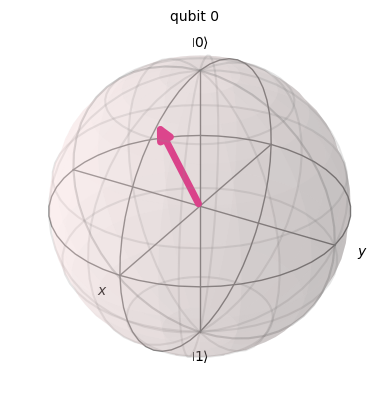

In [11]:
# Display it nicely.
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere.
plot_bloch_multivector(psi)

In [12]:
# Create a circuit to hold this initial state and append it to the front of a teleportation circuit.
initial_state_circuit = QuantumCircuit(qr1, qr2, qr3, crz, crx)
initial_state_circuit.append(init_gate, [0])
teleportation_circuit = initial_state_circuit.compose(teleportation_circuit)
teleportation_circuit.draw()

┌───────────────────────────────────────────┐      ░      ┌───┐ ░ ┌─┐»
  alice: ┤ init(-0.25785-0.71436j,-0.30963+0.57213j) ├──────░───■──┤ H ├─░─┤M├»
         └───────────────────┬───┬───────────────────┘      ░ ┌─┴─┐└───┘ ░ └╥┘»
channel: ────────────────────┤ H ├──────────────────────■───░─┤ X ├──────░──╫─»
                             └───┘                    ┌─┴─┐ ░ └───┘      ░  ║ »
    bob: ─────────────────────────────────────────────┤ X ├─░────────────░──╫─»
                                                      └───┘ ░            ░  ║ »
  crz: 1/═══════════════════════════════════════════════════════════════════╩═»
                                                                            0 »
  crx: 1/═════════════════════════════════════════════════════════════════════»
                                                                              »
«             ░               
«  alice: ────░───────────────
«         ┌─┐ ░               
«channel: ┤M├─░───────────────
«         └╥┘ ░  ┌───┐  ┌───┐ 
«    bob: ─╫──░──┤ X ├──┤ Z ├─
«          ║  ░  └─╥─┘  └─╥─┘ 
«          ║       ║   ┌──╨──┐
«  crz: 1/═╬═══════╬═══╡ 0x1 ╞
«          ║    ┌──╨──┐└─────┘
«  crx: 1/═╩════╡ 0x1 ╞═══════
«          0    └─────┘

We can see below, using the statevector obtained from the Aer simulator, that the state of $|q_2\rangle$ is the same as what was randomly generated to initialize $|\psi\rangle$, above.

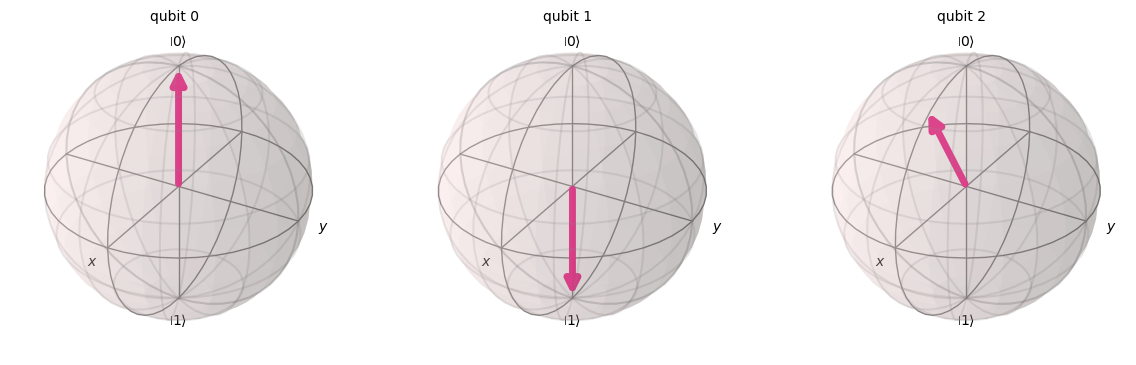

In [13]:
sim = Aer.get_backend('aer_simulator')
teleportation_circuit.save_statevector()
out_vector = sim.run(teleportation_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

# Your Task: Program a quantum repeater using an entanglement swapping circuit.

Step 1: Read the following background information.

An entanglement swap circuit is built with the following steps:
1. Create two entangled pairs: qubits 1,2 and qubits 3,4.
2. Add a Bell state measurement between qubits 2 and 3 that swaps parts of the entanglement. This portion of the circuit is what lends the circuit its name of 'entanglement swapper.'

The circuit looks like:

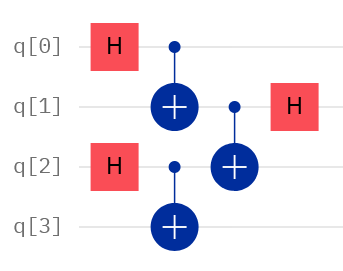

Step 2: Read the following background information.

Multiple entanglement swappers can be used to repeat quantum states across distances (_i.e_, to _teleport_ a quantum state from point A to point B).  For more information, you can see the paper here (https://www.researchgate.net/publication/337932652_One_Layer_Demonstration_of_Quantum_Internet_on_the_IBM_Q_System), but note that the Toffoli and $Z$-gate in Figure 1 should be ignored in the context of this problem.

The quantum repeater strcture from that paper is:
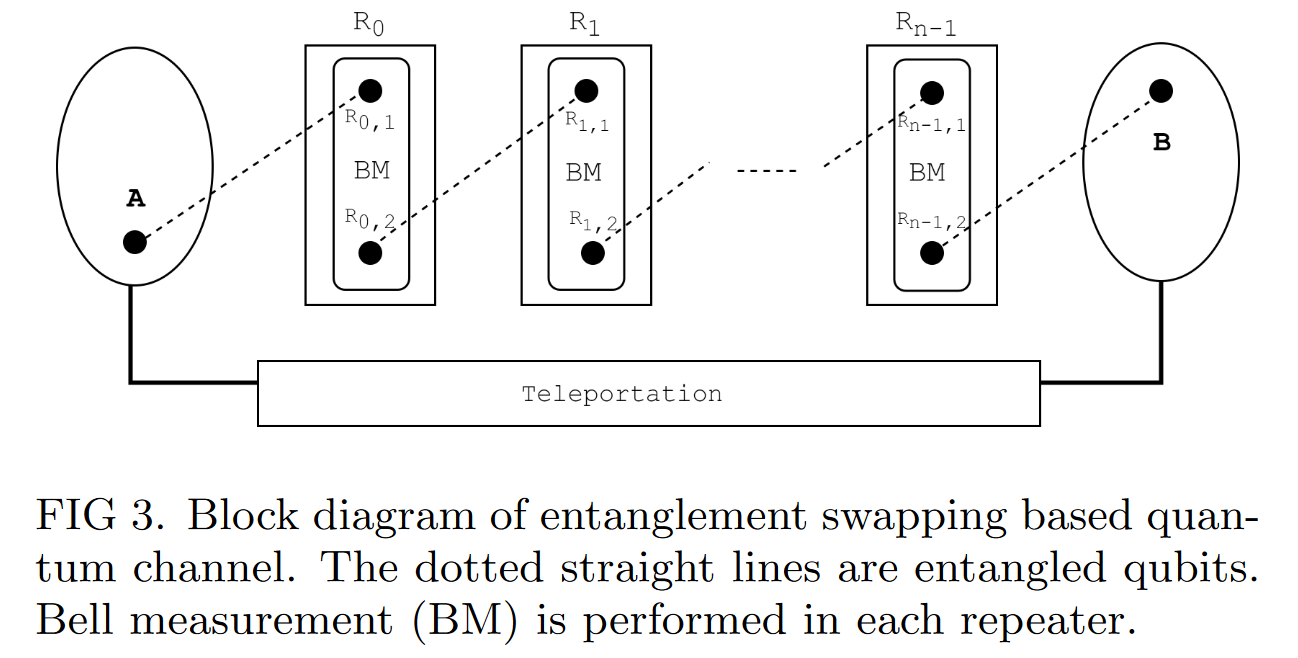

Step 3: Program a quantum repeater using:
1. The entanglement swap circuit specification above.

__and__

2. The teleportation demo as a guide to the required `qiskit` functionality.

Specifically:

1. Create the entanglement swapping teleportation circuit.

2. Use `statevector.from_label` and `Initialize` to initialize a circuit with a specific input.

3. Use `circuit1.compose(circuit2)` to add the entanglement swapping circuit to the end of the initialized input circuit.

4. Apply multiple entanglement swapping circuits to create a repeater. Specifically, try adding 16 of these using a for loop.  What do you notice?  (Hint: See "Goal" below!)

5. Test your circuit and illustrate its functionality using either:

    1. Statevector simulation and simulator measurement ouput.
    __Or__
    2. Bloch sphere representation and simulator measurement output.

__Goal__: The values of output measurement should be the same as the input vector after 16 applications of the entanglement swap circuit.  Please note that if your code does not exhibit this behavior, then it contains an error, and points will be deducted.  Please also note that if your submitted homework does not clearly show that your circuit has the desired output (using one of the two output methods above), then points will be deducted.

In [14]:
# Insert your code here.

In [15]:
# entanglement swap circuit

In [16]:
from qiskit.result import Counts, marginal_counts
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.circuit.library import RXGate

In [17]:
class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: QuantumRegister, b: QuantumRegister,) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[1], b[0])
        qc.h(a[1])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: QuantumRegister, b: QuantumRegister) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[1], 0)
        qc.measure(b[0], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, b: QuantumRegister, bsm_z: ClassicalRegister, bsm_x: ClassicalRegister) -> None:
        if self.barrier: qc.barrier()
        qc.x(b[1]).c_if(bsm_x, 1)
        qc.z(b[1]).c_if(bsm_z, 1)

In [18]:
class QuantumVisualizations:
    def display_statevector_as_array(self, psi: Statevector) -> None:
        display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
    
    def display_bloch_statevector(self, psi: Statevector):
        return plot_bloch_multivector(psi)


In [19]:
class QuantumNativeSimulations:
    def statevector_sim(self, qc: QuantumCircuit) -> Statevector:
        state_sim: StatevectorSimulator = StatevectorSimulator()
        return state_sim.run(transpile(qc, state_sim)).result().get_statevector()
    def qasm_sim(self, qc: QuantumCircuit) -> Counts:
        qasm_sim: QasmSimulator = QasmSimulator()
        return qasm_sim.run(transpile(qc, qasm_sim), shots=1024).result().get_counts()

In [20]:
alice: QuantumRegister = QuantumRegister(2, "alice")
bob: QuantumRegister = QuantumRegister(2, "bob")

bsm_z: ClassicalRegister = ClassicalRegister(1, "zresult")
bsm_x: ClassicalRegister = ClassicalRegister(1, "xresult")

coz: ClassicalRegister = ClassicalRegister(1, "coz")
cox: ClassicalRegister = ClassicalRegister(1, "cox")

qc: QuantumCircuit = QuantumCircuit(alice, bob, bsm_z, bsm_x, coz, cox)


In [21]:
qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qv: QuantumVisualizations = QuantumVisualizations()


In [22]:
psi: Statevector = qco.create_random_statevector(2)
init_instruction: Initialize = Initialize(psi)
init_instruction.label = "init"

qc.append(init_instruction, [alice[0]])

qco.create_bell_pairs(qc, [alice, bob])

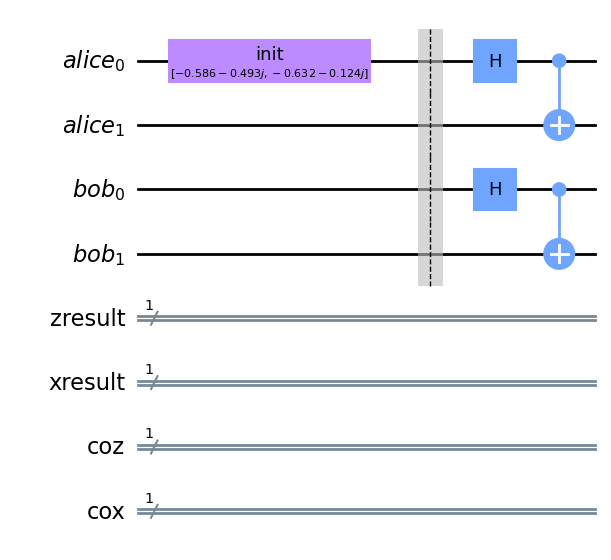

In [23]:
qc.draw("mpl", fold=-1)

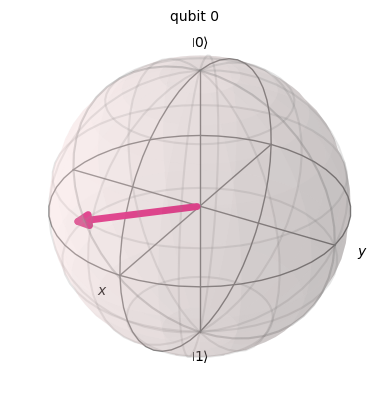

In [24]:
qns: QuantumNativeSimulations = QuantumNativeSimulations()

vector_state: Statevector = qns.statevector_sim(qc)
qv.display_bloch_statevector(psi)

In [25]:
qco.bell_state_operation(qc, alice, bob)
qco.bell_state_measurement(qc, alice, bob)
qco.pauli_correction_operation(qc, bob, bsm_z, bsm_x)
vector_state: Statevector = qns.statevector_sim(qc)


In [26]:
qc.barrier()
qc.cx(alice[0], bob[1])
qc.h(alice[0])

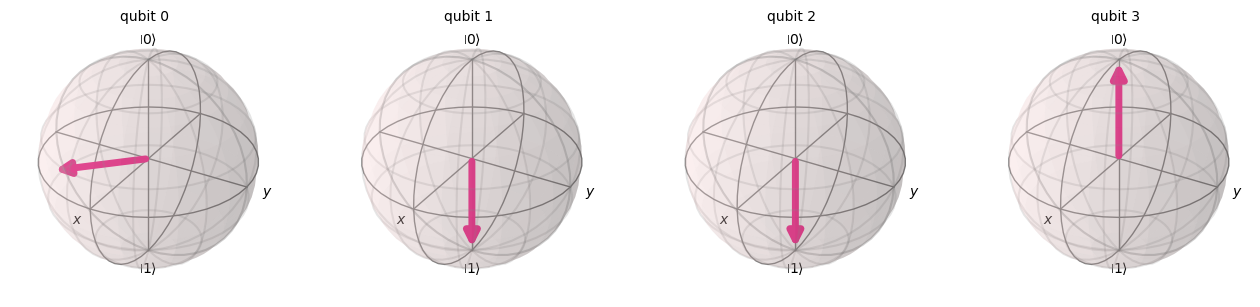

In [27]:
vector_state: Statevector = qns.statevector_sim(qc)
qv.display_bloch_statevector(vector_state)

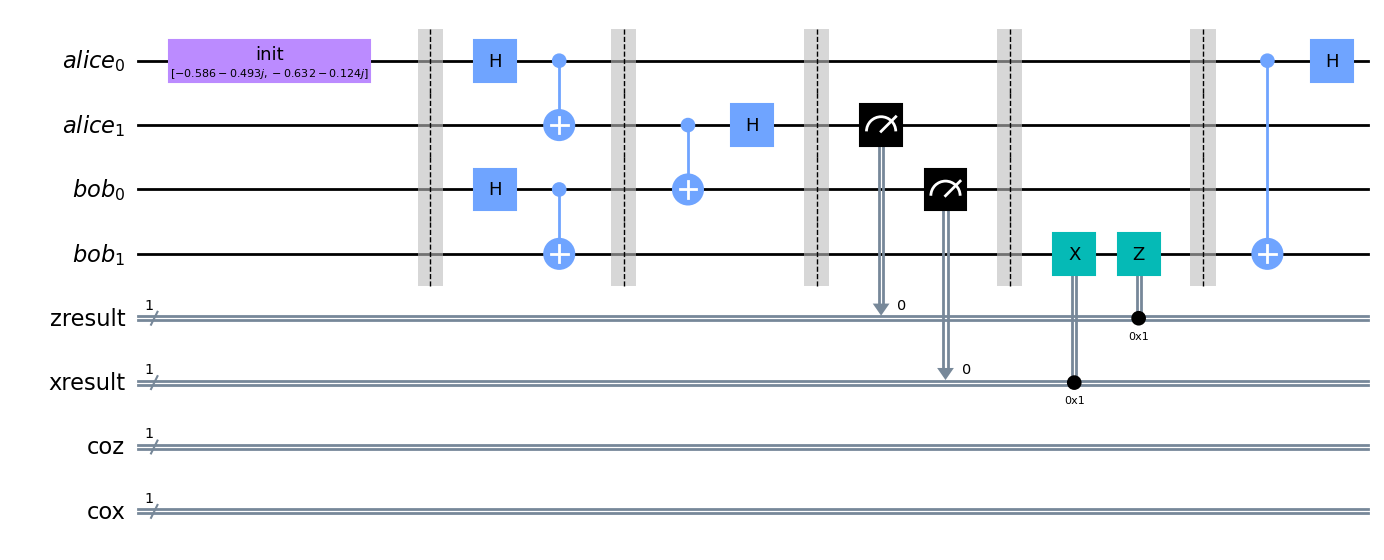

In [28]:
qc.draw("mpl", fold=-1)

In [29]:
# Repeater

In [30]:
class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: QuantumRegister) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[0], a[1])
        qc.h(a[0])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: QuantumRegister) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[0], 0)
        qc.measure(a[1], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, b: QuantumRegister, bsm_z: ClassicalRegister, bsm_x: ClassicalRegister) -> None:
        if self.barrier: qc.barrier()
        qc.x(b).c_if(bsm_x, 1)
        qc.z(b).c_if(bsm_z, 1)


In [31]:
qgen_alice: QuantumRegister = QuantumRegister(2, "qgen_alice")
qgen_bob: QuantumRegister = QuantumRegister(2, "qgen_bob")

swap_channel: QuantumRegister = QuantumRegister(16, "channel")

qmem: QuantumRegister = QuantumRegister(2, "qmem")

alice: QuantumRegister = QuantumRegister(1, "alice")
bob: QuantumRegister = QuantumRegister(1, "bob")

bsm_z: ClassicalRegister = ClassicalRegister(1, "zresult")
bsm_x: ClassicalRegister = ClassicalRegister(1, "xresult")

coz: ClassicalRegister = ClassicalRegister(1, "coz")
cox: ClassicalRegister = ClassicalRegister(1, "cox")

qc: QuantumCircuit = QuantumCircuit(qgen_alice, qgen_bob, qmem, alice, bob, swap_channel, bsm_z, bsm_x, coz, cox)

qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qns: QuantumNativeSimulations = QuantumNativeSimulations()
qco.create_bell_pairs(qc, [qgen_alice, qgen_bob])

In [32]:
qc.barrier()
qc.swap(qgen_alice[0], qmem[0])
qc.swap(qgen_alice[1], alice)
qc.swap(qgen_bob[0], qmem[1])
qc.swap(qgen_bob[1], bob)

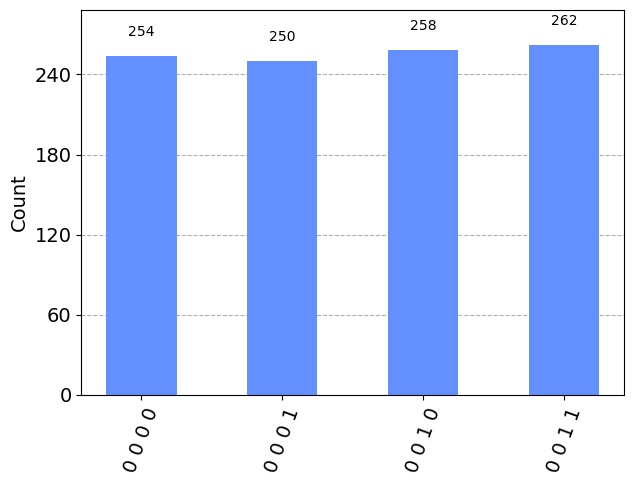

In [33]:
qc.barrier()
qc.swap(qmem[0], swap_channel[0])
qc.swap(qmem[1], swap_channel[1])
for i in range(14):
    qc.swap(swap_channel[i], swap_channel[i+2])
    
qc.barrier()
qc.cx(swap_channel[14],swap_channel[15])
qc.h(swap_channel[14])

qc.measure(swap_channel[14], bsm_z)
qc.measure(swap_channel[15], bsm_x)

qco.pauli_correction_operation(qc, bob, bsm_z, bsm_x)
qc.barrier()
qc.cx(alice, bob)
qc.h(alice)

qc.barrier()
qc.measure(alice, coz)
qc.measure(bob, cox)

counts: Counts = qns.qasm_sim(qc)
plot_histogram(counts)

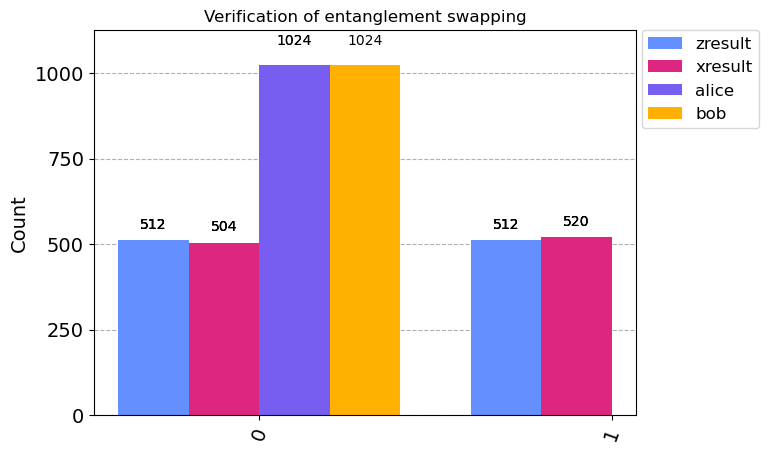

In [34]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(4)]
legend: list = ["zresult", "xresult", "alice", "bob"]
plot_histogram(qubit_counts, legend=legend, title="Verification of entanglement swapping")

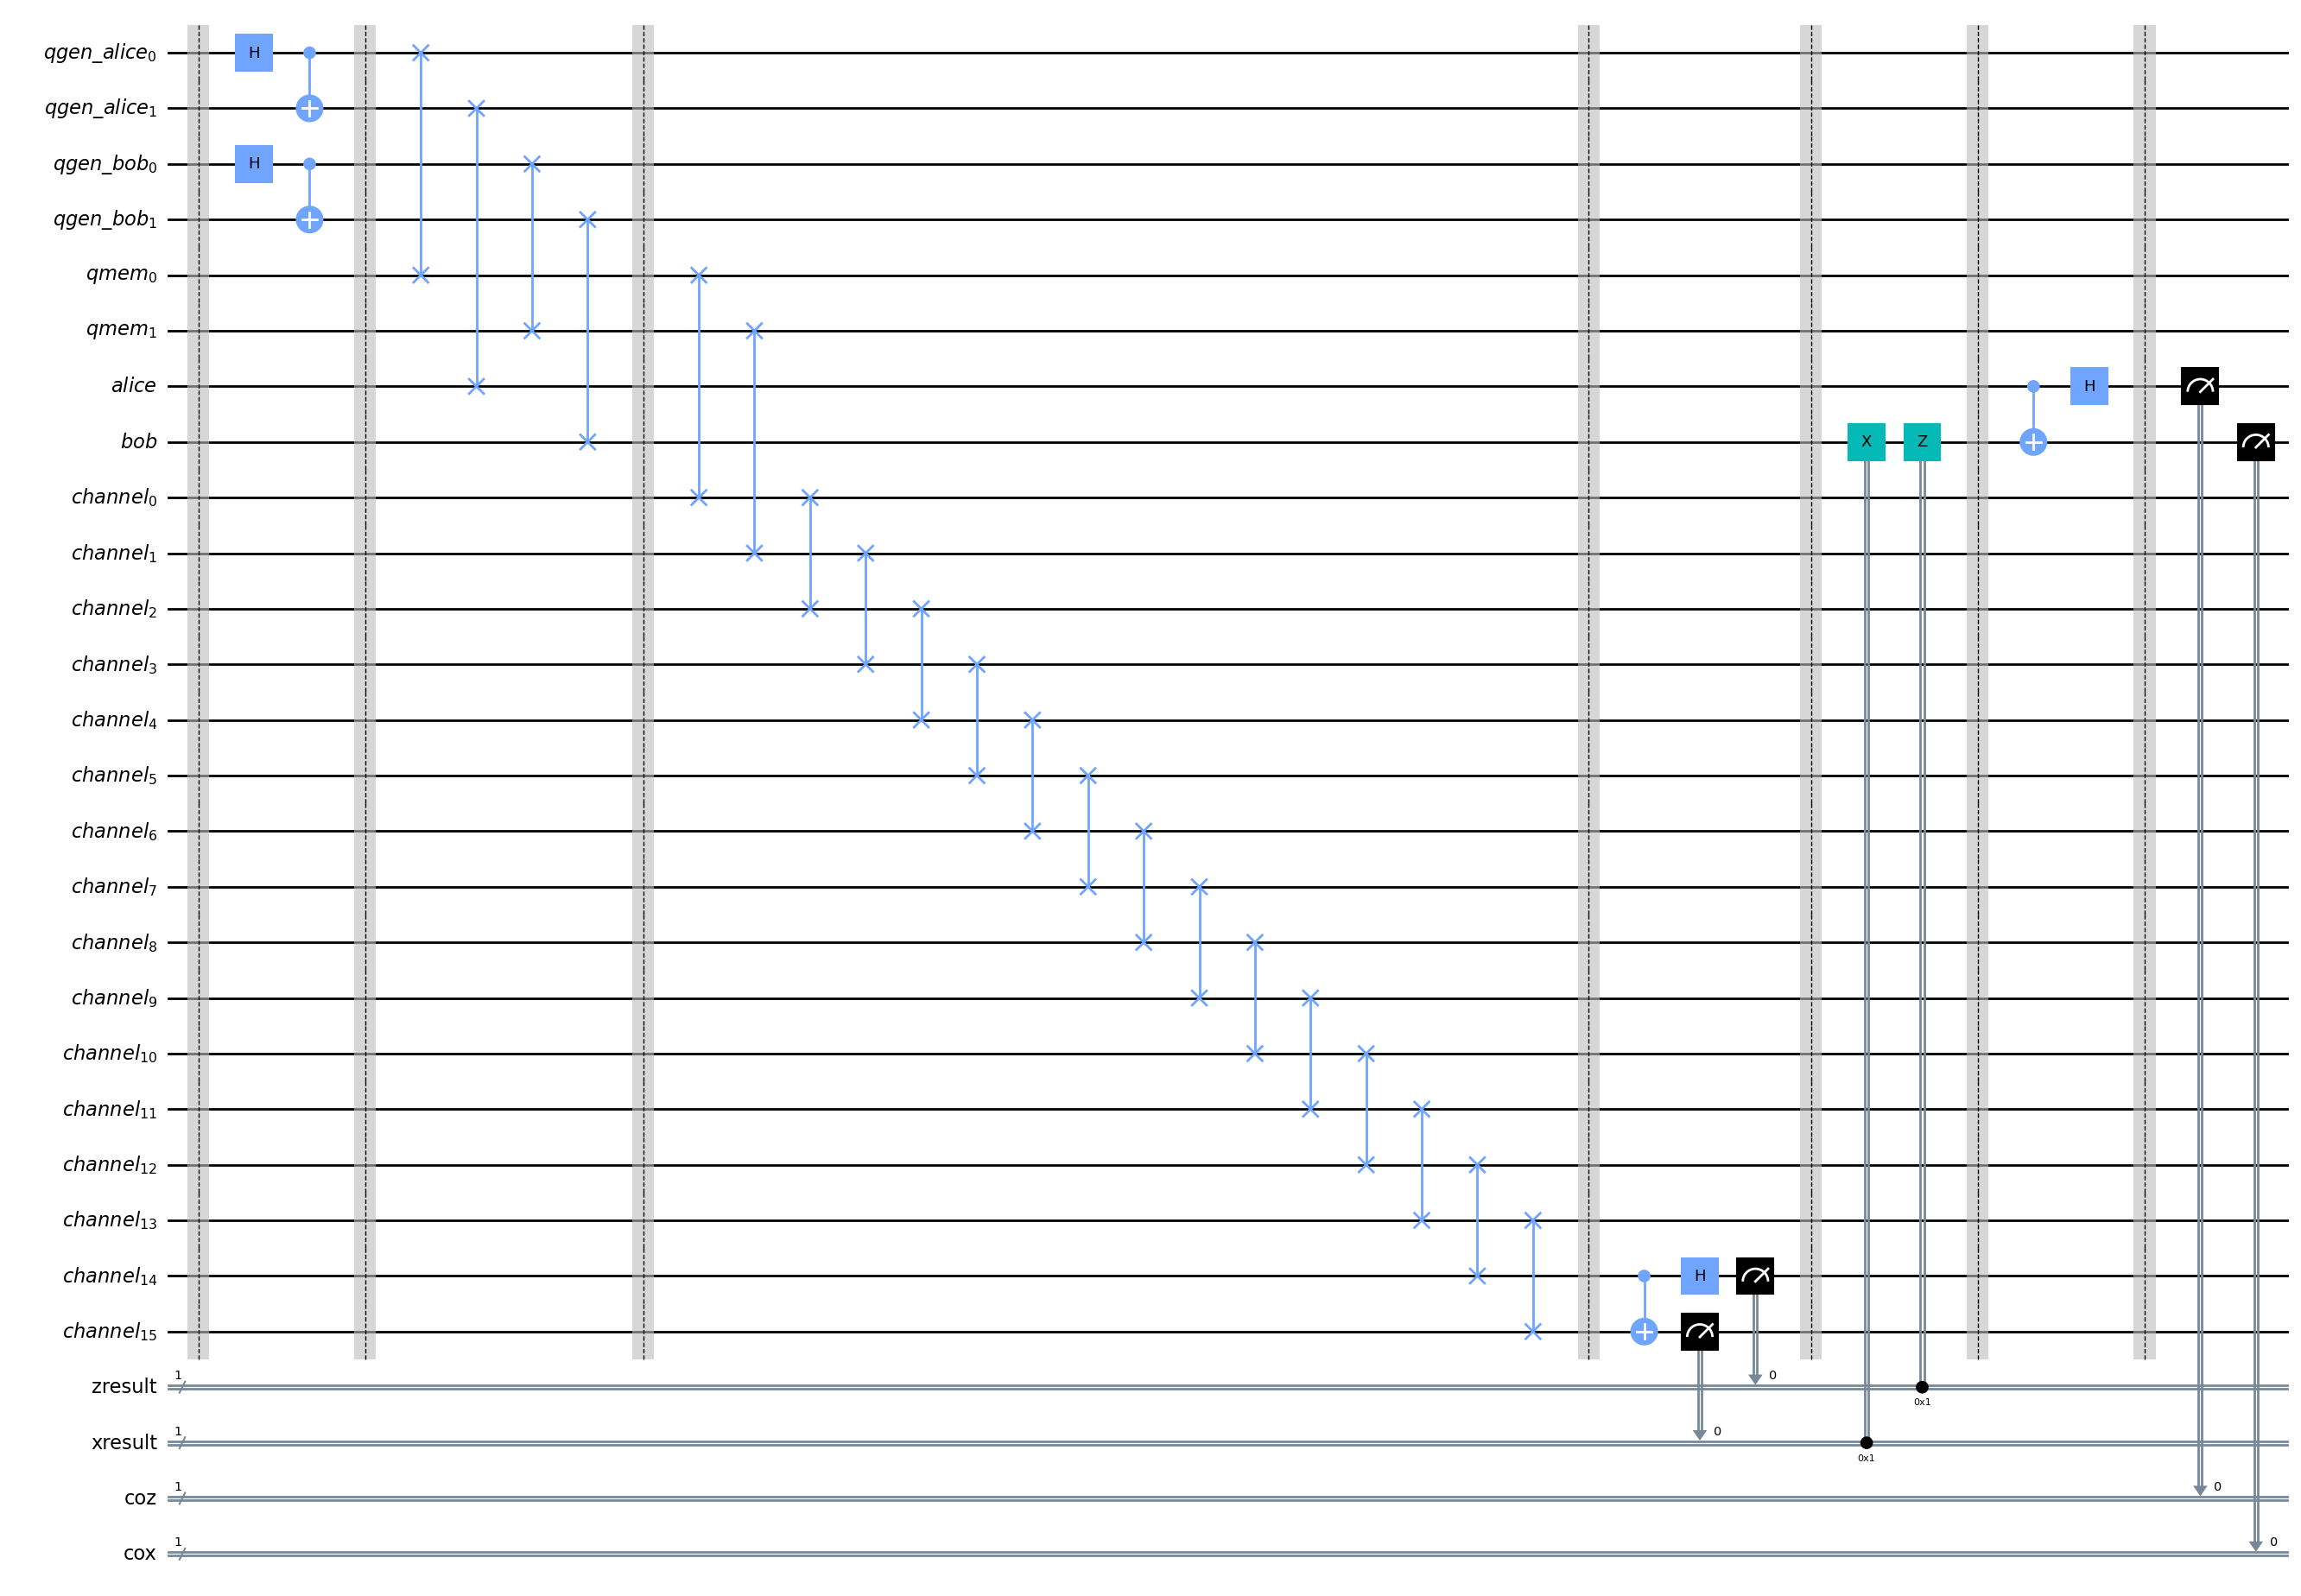

In [35]:
 qc.draw("mpl", fold=-1)

Export this Notebook to either PDF or HTML, and send it to mitch@mail.smu, erhenderson@mail.smu, and hendersonj@smu.edu.